In [ ]:
import pandas as pd
import pymysql
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
from tensorly.decomposition import parafac
#
import math
#
# Remove the limit on column width
pd.set_option('display.max_colwidth', None)

In [2]:
import custom_functions_katerina
from importlib import reload
reload(custom_functions_katerina)
#
from custom_functions_katerina import(
    find_outliers,
    )

In [3]:
df = pd.read_csv('values.csv')
df_c = pd.read_csv('countries.csv')
df_i = pd.read_csv('indicators.csv')

# General Check of the dataframe

In [4]:
#joining to insert the region in the values table
df_ = pd.merge(df,df_c, on='country_id',how='left' )

In [5]:
#join to insert information about the indicators
df_c_i = pd.merge(df_, df_i, on='indicator_id', how = 'left')

In [6]:
df_.isna().sum()

country_id        0
indicator_id      0
year              0
value             0
country_name    288
region          288
dtype: int64

In [7]:
df_c_i.isna().sum()

country_id          0
indicator_id        0
year                0
value               0
country_name      288
region            288
indicator_name      0
unit                0
dtype: int64

It has some NANs as it has some countries that are not present in the countries table.
#Hence we delete those values

In [8]:
#Investigating which countries are these
df_countries_missing = set(df['country_id']) - set(df_c['country_id']) #not in df_C
df_countries_missing
df_countries_missing_fromc = set(df_c['country_id']) - set(df['country_id']) 
df_countries_missing_fromc
print(df_countries_missing , df_countries_missing_fromc) # find the difference in countries to see if to delete


{'ABW', 'AFW', 'AFE', 'AFG'} set()


These countries are small appart from AFW (Afganistan) which is also included in other regions
So we have made a decision to drop them

In [9]:
df_.dropna(inplace=True)
df_c_i.dropna(inplace=True)

In [10]:
df_c_i.reset_index(drop=True, inplace=True)
df_.reset_index(drop=True, inplace=True)

Investigate which countries belong within the regions we have defined

In [11]:
df_regions_countries = df_.groupby('region')['country_id'].unique().reset_index()
df_regions_countries

,region,country_id
0,Africa,"[AGO, BDI, BEN, BFA, BWA, CAF, CIV, CMR, COD, COG, COM, CPV, ERI, ETH, GAB, GHA, GIN, GMB, GNB, GNQ, KEN, LBR, LSO, MDG, MLI, MOZ, MRT, MUS, MWI, NAM, NER, NGA, RWA, SDN, SEN, SLE, SOM, SSD, STP, SWZ, SYC, TCD, TGO, TZA, UGA, ZAF, ZMB, ZWE]"
1,East Asia and Pacific,"[BRN, CHN, GUM, HKG, IDN, JPN, KHM, KOR, LAO, MAC, MMR, MNG, MNP, MYS, PHL, PNG, PRK, SGP, THA, TLS, VNM]"
2,Europe and Central Asia,"[ALB, AND, ARM, AUT, AZE, BEL, BGR, BIH, BLR, CHE, CHI, CYP, CZE, DEU, DNK, ESP, EST, FIN, FRA, FRO, GBR, GEO, GIB, GRC, GRL, HRV, HUN, IMN, IRL, ISL, ITA, KAZ, KGZ, LIE, LTU, LUX, LVA, MCO, MDA, MKD, MLT, MNE, NLD, NOR, POL, PRT, ROU, RUS, SMR, SRB, SVK, SVN, SWE, TJK, TKM, TUR, UKR, UZB, XKX]"
3,Latin America and the Caribbean,"[ARG, ATG, BHS, BLZ, BMU, BOL, BRA, BRB, CHL, COL, CRI, CUB, CUW, CYM, DMA, DOM, ECU, GRD, GTM, GUY, HND, HTI, JAM, KNA, LCA, MAF, MEX, NIC, PAN, PER, PRY, SLV, SUR, SXM, TCA, TTO, URY, VCT, VEN, VGB, VIR]"
4,"Middle East, North Africa, Afghanistan & Pakistan","[ARE, BHR, DJI, DZA, EGY, IRN, IRQ, ISR, JOR, KWT, LBN, LBY, MAR, OMN, PAK, PSE, QAT, SAU, SYR, TUN, YEM]"
5,North America,"[CAN, PRI, USA]"
6,OCEANIA,"[ASM, AUS, FJI, FSM, KIR, MHL, NCL, NRU, NZL, PLW, PYF, SLB, TON, TUV, VUT, WSM]"
7,REGION,"[ARB, CEB, CSS, EAS, ECS, LCN, MEA, NAC, OSS, PSS, SAS, SSF, SST, WLD]"
8,SOCIOECONOMIC,"[EAP, EAR, ECA, EMU, EUU, FCS, HIC, HPC, IBD, IBT, IDA, IDB, IDX, LAC, LDC, LIC, LMC, LMY, LTE, MIC, MNA, OED, PRE, PST, SSA, TEA, TEC, TLA, TMN, TSA, TSS, UMC]"
9,South Asia,"[BGD, BTN, IND, LKA, MDV, NPL]"


In [12]:
df_regions_countries

,region,country_id
0,Africa,"[AGO, BDI, BEN, BFA, BWA, CAF, CIV, CMR, COD, COG, COM, CPV, ERI, ETH, GAB, GHA, GIN, GMB, GNB, GNQ, KEN, LBR, LSO, MDG, MLI, MOZ, MRT, MUS, MWI, NAM, NER, NGA, RWA, SDN, SEN, SLE, SOM, SSD, STP, SWZ, SYC, TCD, TGO, TZA, UGA, ZAF, ZMB, ZWE]"
1,East Asia and Pacific,"[BRN, CHN, GUM, HKG, IDN, JPN, KHM, KOR, LAO, MAC, MMR, MNG, MNP, MYS, PHL, PNG, PRK, SGP, THA, TLS, VNM]"
2,Europe and Central Asia,"[ALB, AND, ARM, AUT, AZE, BEL, BGR, BIH, BLR, CHE, CHI, CYP, CZE, DEU, DNK, ESP, EST, FIN, FRA, FRO, GBR, GEO, GIB, GRC, GRL, HRV, HUN, IMN, IRL, ISL, ITA, KAZ, KGZ, LIE, LTU, LUX, LVA, MCO, MDA, MKD, MLT, MNE, NLD, NOR, POL, PRT, ROU, RUS, SMR, SRB, SVK, SVN, SWE, TJK, TKM, TUR, UKR, UZB, XKX]"
3,Latin America and the Caribbean,"[ARG, ATG, BHS, BLZ, BMU, BOL, BRA, BRB, CHL, COL, CRI, CUB, CUW, CYM, DMA, DOM, ECU, GRD, GTM, GUY, HND, HTI, JAM, KNA, LCA, MAF, MEX, NIC, PAN, PER, PRY, SLV, SUR, SXM, TCA, TTO, URY, VCT, VEN, VGB, VIR]"
4,"Middle East, North Africa, Afghanistan & Pakistan","[ARE, BHR, DJI, DZA, EGY, IRN, IRQ, ISR, JOR, KWT, LBN, LBY, MAR, OMN, PAK, PSE, QAT, SAU, SYR, TUN, YEM]"
5,North America,"[CAN, PRI, USA]"
6,OCEANIA,"[ASM, AUS, FJI, FSM, KIR, MHL, NCL, NRU, NZL, PLW, PYF, SLB, TON, TUV, VUT, WSM]"
7,REGION,"[ARB, CEB, CSS, EAS, ECS, LCN, MEA, NAC, OSS, PSS, SAS, SSF, SST, WLD]"
8,SOCIOECONOMIC,"[EAP, EAR, ECA, EMU, EUU, FCS, HIC, HPC, IBD, IBT, IDA, IDB, IDX, LAC, LDC, LIC, LMC, LMY, LTE, MIC, MNA, OED, PRE, PST, SSA, TEA, TEC, TLA, TMN, TSA, TSS, UMC]"
9,South Asia,"[BGD, BTN, IND, LKA, MDV, NPL]"


Find which Years the dataset spans

In [13]:
df_['year'].unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019])

In [14]:
#Create a datafame with all the information from the 3 matrices, and without SOCIOECONOMIC and REGION
df_all = df_c_i[~df_c_i['region'].isin(['REGION', 'SOCIOECONOMIC'])]
df_all.head()

,country_id,indicator_id,year,value,country_name,region,indicator_name,unit
0,AGO,CHE,2008,3.322903,Angola,Africa,Current health expenditure,% of GDP
1,AGO,CHE,2009,3.842608,Angola,Africa,Current health expenditure,% of GDP
2,AGO,CHE,2010,2.695100,Angola,Africa,Current health expenditure,% of GDP
3,AGO,CHE,2011,2.645608,Angola,Africa,Current health expenditure,% of GDP
4,AGO,CHE,2012,2.395750,Angola,Africa,Current health expenditure,% of GDP


# Outliers

The two rows (REGION and SOCIOECONOMIC) do not contain actual countries. They contain aggregate codes used by the World Bank.

Row 7 (REGION): Contains codes like ARB (Arab World), EAS (East Asia & Pacific aggregate), LCN (Latin America & Caribbean aggregate). These are broad groupings, not individual nations.

Row 8 (SOCIOECONOMIC): Contains codes like HIC (High Income), LDC (Least Developed Countries), UMC (Upper Middle Income). These represent economic brackets  

**We are excluding them**


## 3ai Detect outliers for each indicator and for each region over the last 10 year

In [15]:
# --- TASK (i): OUTLIERS (LAST 10 YEARS) ---

# Filter for the last 10 years a(REGION and SOCIOECONOMIC labeled regions but do not contain countries --REMOVE)
# In our case this is not necessary as data was cleaned to only include 2008-2019
df_10years = df_[df_['year'] >= 2010].copy()
#If region is "REGION" or "SOCIOECONOMIC" we remove those rows
df_outliers = df_10years[~df_10years['region'].isin(['REGION', 'SOCIOECONOMIC'])]


In [104]:
df_outliers['country_id'].nunique()

215

In [16]:
df_outliers['region'].unique()

array(['Africa', 'Europe and Central Asia',
       'Middle East, North Africa, Afghanistan & Pakistan',
       'Latin America and the Caribbean', 'OCEANIA', 'South Asia',
       'East Asia and Pacific', 'North America'], dtype=object)

In [17]:
df_outliers = find_outliers(df_outliers)

In [18]:
df_outliers.head()

,country_id,indicator_id,year,value,country_name,region,mean,std,z_score,is_outlier
2,AGO,CHE,2010,2.695100,Angola,Africa,5.274319,2.489517,-1.036032,0
3,AGO,CHE,2011,2.645608,Angola,Africa,5.274319,2.489517,-1.055912,0
4,AGO,CHE,2012,2.395750,Angola,Africa,5.274319,2.489517,-1.156276,0
5,AGO,CHE,2013,2.732827,Angola,Africa,5.274319,2.489517,-1.020878,0
6,AGO,CHE,2014,2.434129,Angola,Africa,5.274319,2.489517,-1.140860,0


In [19]:
#Find the countries with the most outliers within those 10 years selected
df_isoutlier = df_outliers[df_outliers['is_outlier'] == 1]
df_counts_percountry = df_isoutlier.groupby(['country_id','indicator_id','year'])['value'].count()

In [20]:
#we have this matrix which shows which country, region, indicator, value and z-score of the outlier
df_isoutlier.head()

,country_id,indicator_id,year,value,country_name,region,mean,std,z_score,is_outlier
674,AUS,GEM,2010,6.438945e+02,Australia,OCEANIA,6.450921e+01,1.725066e+02,3.358627,1
675,AUS,GEM,2011,6.160435e+02,Australia,OCEANIA,6.450921e+01,1.725066e+02,3.197178,1
676,AUS,GEM,2012,5.943439e+02,Australia,OCEANIA,6.450921e+01,1.725066e+02,3.071388,1
677,AUS,GEM,2013,6.008677e+02,Australia,OCEANIA,6.450921e+01,1.725066e+02,3.109206,1
686,AUS,POP,2010,2.203175e+07,Australia,OCEANIA,1.956852e+06,5.732755e+06,3.501789,1


In [21]:
#Outliers per region  for all indicators and year and their percentage within the total outliers
df_outliers_region = df_isoutlier['region'].value_counts().reset_index()
df_outliers_region['perc%'] = df_outliers_region['count'] * 100 / len(df_isoutlier)
round(df_outliers_region,2)

,region,count,perc%
0,Europe and Central Asia,63,27.04
1,Africa,54,23.18
2,Latin America and the Caribbean,52,22.32
3,"Middle East, North Africa, Afghanistan & Pakistan",27,11.59
4,East Asia and Pacific,21,9.01
5,OCEANIA,16,6.87


In [22]:
#outliers as per country
df_outliers_country = df_isoutlier[['country_id','region']].value_counts().reset_index()
df_outliers_country.sort_values('count', ascending = False)

,country_id,region,count
0,CHN,East Asia and Pacific,20
1,BRA,Latin America and the Caribbean,20
2,HTI,Latin America and the Caribbean,20
3,ZAF,Africa,20
4,NGA,Africa,20
5,PAK,"Middle East, North Africa, Afghanistan & Pakistan",20
6,RUS,Europe and Central Asia,19
7,AUS,OCEANIA,14
8,DEU,Europe and Central Asia,10
9,ISL,Europe and Central Asia,10


Outliers by indicator

In [23]:
df_outliers_indicator = df_isoutlier['indicator_id'].value_counts().reset_index()
df_outliers_indicator.sort_values('count', ascending = False)

,indicator_id,count
0,GEM,67
1,POP,63
2,WU,33
3,WR,21
4,REN,20
5,SU,16
6,CHE,11
7,SR,2


Zscore scatter plot for one indicator

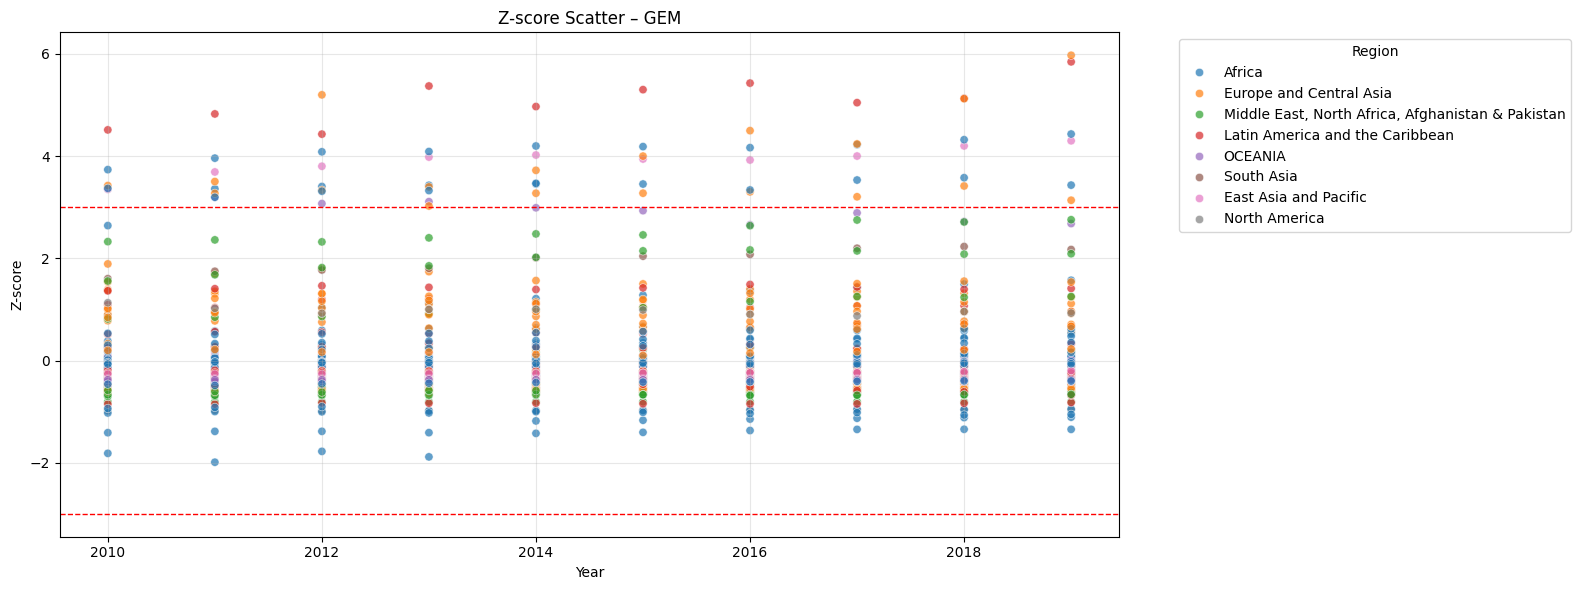

In [24]:
indicator = "GEM"

subset = df_outliers[df_outliers["indicator_id"] == indicator]

plt.figure(figsize=(16, 6))

sns.scatterplot(
    data=subset,
    x="year",
    y="z_score",
    hue="region",
    alpha=0.7
)

# Outlier thresholds
plt.axhline(3, color="red", linestyle="--", linewidth=1)
plt.axhline(-3, color="red", linestyle="--", linewidth=1)

plt.title(f"Z-score Scatter – {indicator}")
plt.ylabel("Z-score")
plt.xlabel("Year")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 3aii Select a specific region and get the outliers for each indicator for intervals of 10 years

We will select the region with the most outliers "Europe and Central Asia" and we will compute the outliers for each indicator for each indecator for intervals of 10 years  

Since our data are from 2008 to 2019 included, we are only going to take the outliers for every 2 years


In [25]:
df_all['year'].unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019])

In [26]:
#Separate the values for the selected region in a dictinalry
df_all_eu = df_all[df_all['region'] == 'Europe and Central Asia']
indicator_list = list(df_all_eu['indicator_id'].unique())
year_list = list(df_all_eu['year'].unique())

In [27]:
df_all_eu.head()

,country_id,indicator_id,year,value,country_name,region,indicator_name,unit
72,ALB,CHE,2008,5.509003,Albania,Europe and Central Asia,Current health expenditure,% of GDP
73,ALB,CHE,2009,5.826039,Albania,Europe and Central Asia,Current health expenditure,% of GDP
74,ALB,CHE,2010,6.236677,Albania,Europe and Central Asia,Current health expenditure,% of GDP
75,ALB,CHE,2011,6.182977,Albania,Europe and Central Asia,Current health expenditure,% of GDP
76,ALB,CHE,2012,6.157462,Albania,Europe and Central Asia,Current health expenditure,% of GDP


In [28]:
"""In order to find outliers for df_all_eu, we will need to find the outliers within the specific region 
and within the specific interval. So now we have different mean and std deviation with respect to the
data distribution. We do not take all years. Only the year intervals"""

#Create a new column which has the lowest year of the interval
#
interval =4
df_all_eu = df_all_eu.copy()
df_all_eu['interval'] = (df_all_eu['year'] // interval)*interval

In [29]:
df_all_eu['interval'].unique() #this has the 1st year of each interval

array([2008, 2012, 2016])

In [ ]:
''' go through the dictionary of selected region and year-interval and group by interval
Then find the outliers for this specific group of values per region and interval
and then save these in a dictionary of results that will be per region, time interval'''
#
results ={}
#find outlier grouping by interval
interval_list = list(set([(year//interval)* interval for year in year_list]))
#
for int in interval_list:
    dX = df_all_eu[df_all_eu['interval'] == int]
    results[int] = find_outliers(dX)
df_results = pd.concat(results.values())   
df_results.reset_index(drop=True,inplace=True) 

Now we have this dataframe where for the selected region of Europe and Central Asia and for 4 year intervals we have found the outliers.

In [35]:
df_results

,country_id,indicator_id,year,value,country_name,region,indicator_name,unit,interval,mean,std,z_score,is_outlier
0,ALB,CHE,2008,5.509003e+00,Albania,Europe and Central Asia,Current health expenditure,% of GDP,2008,7.558517e+00,2.172098e+00,-0.943564,0
1,ALB,CHE,2009,5.826039e+00,Albania,Europe and Central Asia,Current health expenditure,% of GDP,2008,7.558517e+00,2.172098e+00,-0.797606,0
2,ALB,CHE,2010,6.236677e+00,Albania,Europe and Central Asia,Current health expenditure,% of GDP,2008,7.558517e+00,2.172098e+00,-0.608555,0
3,ALB,CHE,2011,6.182977e+00,Albania,Europe and Central Asia,Current health expenditure,% of GDP,2008,7.558517e+00,2.172098e+00,-0.633277,0
4,ALB,GEM,2008,1.359900e+01,Albania,Europe and Central Asia,Total greenhouse gas emissions including LULUCF,Million Tonnes of CO2,2008,1.421887e+02,2.031341e+02,-0.633029,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4423,UZB,WU,2015,9.747529e+01,Uzbekistan,Europe and Central Asia,People using at least basic drinking water services urban,% of Urban Population,2012,9.864886e+01,2.068952e+00,-0.567229,0
4424,XKX,POP,2012,1.807126e+06,Kosovo,Europe and Central Asia,Population total,Humans,2012,1.529498e+07,2.628773e+07,-0.513086,0
4425,XKX,POP,2013,1.818119e+06,Kosovo,Europe and Central Asia,Population total,Humans,2012,1.529498e+07,2.628773e+07,-0.512667,0
4426,XKX,POP,2014,1.812788e+06,Kosovo,Europe and Central Asia,Population total,Humans,2012,1.529498e+07,2.628773e+07,-0.512870,0


Check some graphs to see how it performs

Barchart of total outliers across the the 4-year periods and by Indicator

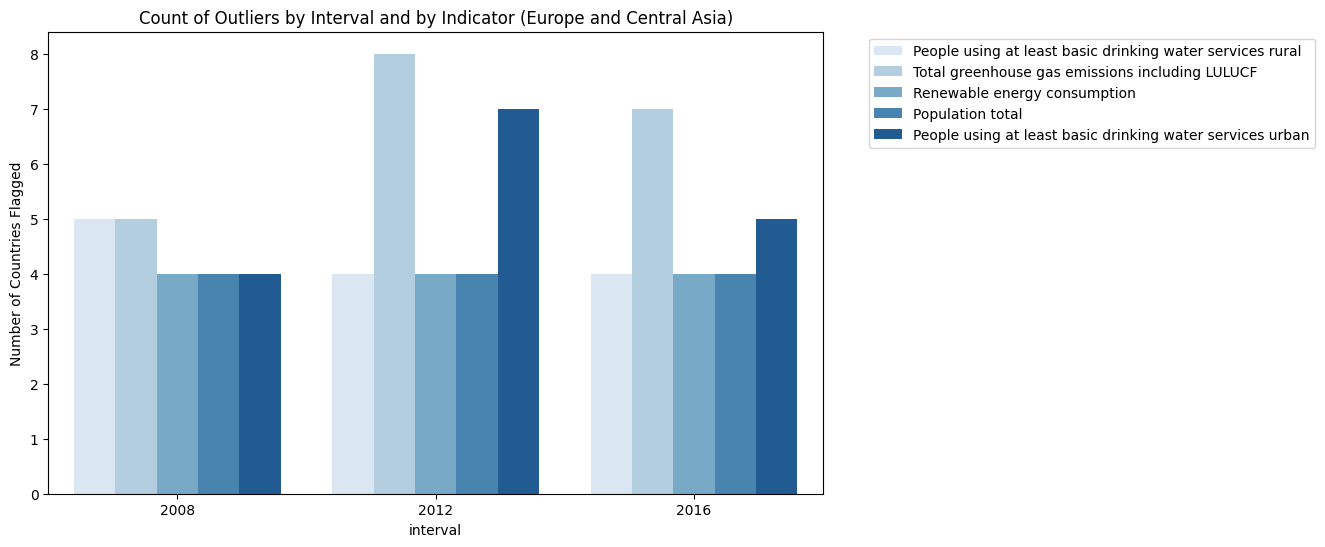

In [44]:
# Filter for outliers only
outliers_only = df_results[df_results['is_outlier'] == 1]

plt.figure(figsize=(10, 6))
sns.countplot(data=outliers_only, x='interval', hue='indicator_name', palette = 'Blues')
plt.title("Count of Outliers by Interval and by Indicator (Europe and Central Asia)")
plt.ylabel("Number of Countries Flagged")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside if it's too big
plt.show()

HeatMap

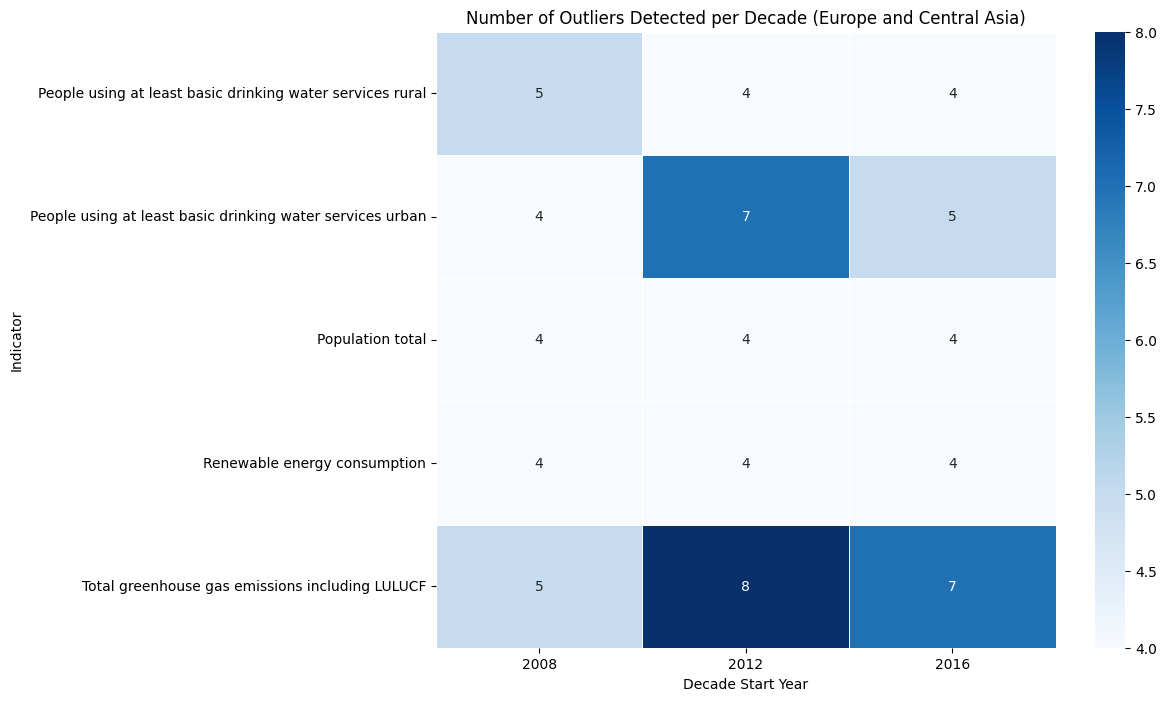

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Pivot the data to count outliers per Indicator/Interval
# We filter for outliers only (is_outlier == 1) then count them
outlier_counts = df_results[df_results['is_outlier'] == 1].pivot_table(
    index='indicator_name', 
    columns='interval', 
    values='country_name', 
    aggfunc='count',
    fill_value=0
)

# 2. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(outlier_counts, annot=True, cmap="Blues", fmt='d', linewidths=.5)
plt.title(f"Number of Outliers Detected per Decade (Europe and Central Asia)")
plt.xlabel("Decade Start Year")
plt.ylabel("Indicator")
plt.show()

ScatterPlot

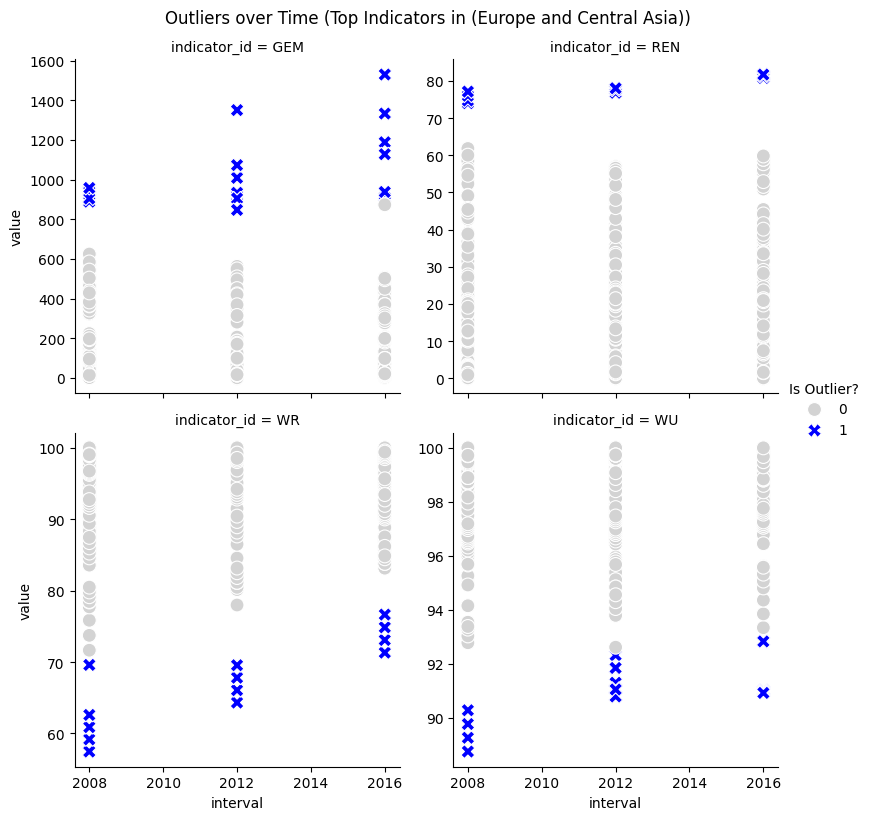

In [53]:

# 1. Select a few key indicators (plotting 50 at once is messy)
# Let's pick the top 4 with the most outliers
top_indicators = df_results[df_results['is_outlier'] == 1]['indicator_id'].value_counts().head(4).index
subset = df_results[df_results['indicator_id'].isin(top_indicators)].copy()

# 2. Create the Facet Grid
g = sns.FacetGrid(subset, col="indicator_id", col_wrap=2, height=4, sharey=False)

# 3. Map the normal points (gray) and outliers (red)
# We map a scatterplot onto the grid
g.map_dataframe(sns.scatterplot, x="interval", y="value", hue="is_outlier", palette={0: "lightgray", 1: "blue"}, style="is_outlier", s=100)

g.add_legend(title="Is Outlier?")
g.fig.suptitle(f"Outliers over Time (Top Indicators in (Europe and Central Asia))", y=1.02)
plt.show()

## 3b Covariance Matrices

In [71]:
''' Use covariance matrices to explore relationships among all features 
(i.e. the indicators, e.g. GPD per capita and inflation). 
This has to be performed for each region over the last 10 years.'''

' Use covariance matrices to explore relationships among all features \n(i.e. the indicators, e.g. GPD per capita and inflation). \nThis has to be performed for each region over the last 10 years.'

We are going to use the df_all dataframe which has all values and excluded the non relevant regions

In [61]:
df_all['indicator_id'].unique()

array(['CHE', 'GEM', 'POP', 'REN', 'WR', 'WU', 'SU', 'SR'], dtype=object)

In [62]:
df_all['year'].unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019])

In [65]:
df_all_10 = df_all[df_all['year'] > 2009]

In [68]:
region_list = list(df_all_10['region'].unique())
region_list

['Africa',
 'Europe and Central Asia',
 'Middle East, North Africa, Afghanistan & Pakistan',
 'Latin America and the Caribbean',
 'OCEANIA',
 'South Asia',
 'East Asia and Pacific',
 'North America']

In [ ]:
#Initial approach that was left out since it does not provide enough granularity
#df_pivot= df_all_10.pivot_table(columns = 'indicator_id', index = 'region', values='value')
#Covariance Matrix
#cov_matrix = df_pivot_region.cov()

Initially we had aggregated over region, but this limits the granularity of the covariance to 
take under consideratoin. So now our index holds all the data for year and country id without aggregating 
on those. The idea is to give plenty of data for the differences to be applied for the evaluation of the 
covariance matrix

This result was run initially with the raw data. But we got no results in teh matrices.
The reason being that all indicators are measured in different units, which means that multiplications on the 
numerator do not make much sense. 
#
We decided to standardize the data on the normal scale, taking normalization factors mu and sigma per indicator.
This is done below in the loop in one line, for the whole table at once with the math package

A different approach would be to use Correlation matrices instead, which is exactly the same as covariance but 
does the standardization first. We run this as well and the results that were produced are exactly the same

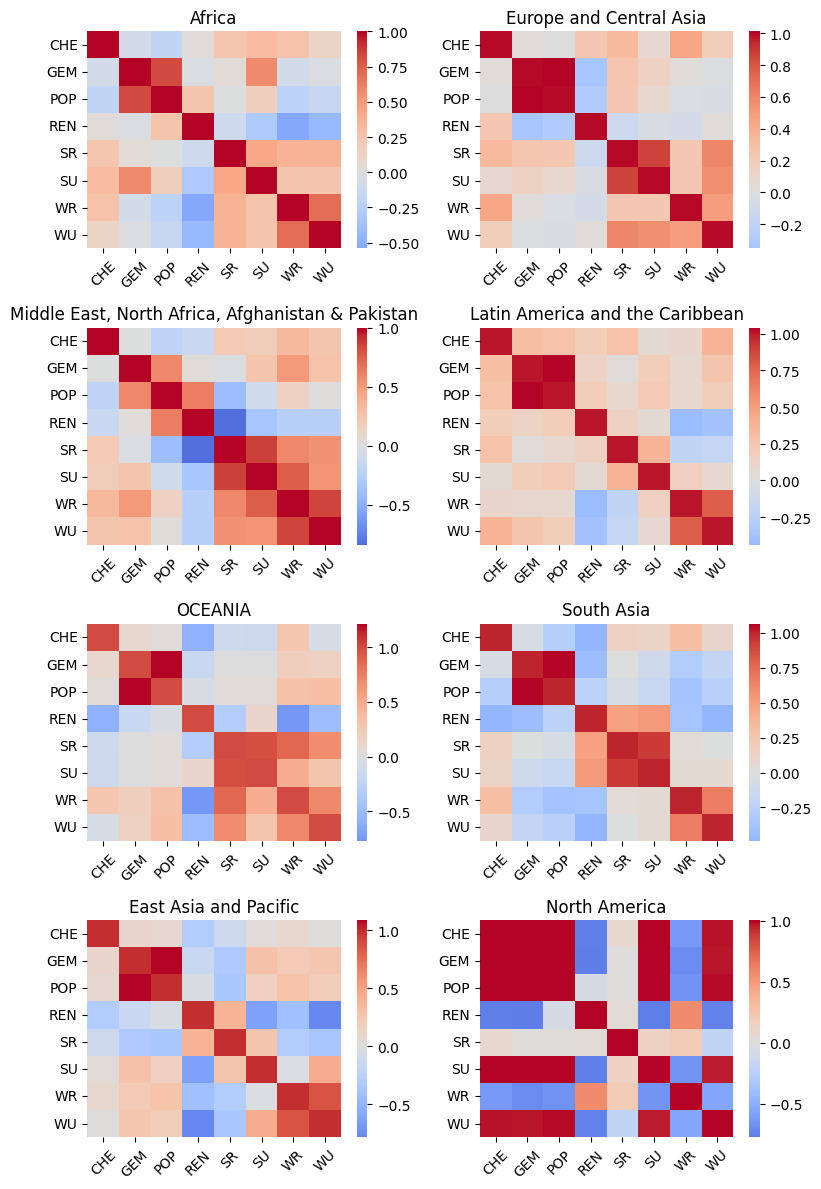

In [93]:
import math
# Setup Data
region_list = list(df_all_10['region'].unique())
cov_matrices = {}

# 2. Setup the "Grid" for plotting
n_regions = len(region_list)
n_cols = 2  # You wanted 2 columns
n_rows = math.ceil(n_regions / n_cols)  # Calculate rows needed (e.g., 5 regions -> 3 rows)

# Create one big figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 3* n_rows))
axes = axes.flatten()  # Flattens the 2D grid into a 1D list [ax0, ax1, ax2...] for easy looping

# Loop through regions and plot on specific axes
for i, region in enumerate(region_list):
    
    # A. Filter & Pivot
    d_region = df_all_10[df_all_10['region'] == region].copy()
    df_pivot = d_region.pivot_table(
        index=['country_id', 'year'], 
        columns='indicator_id', 
        values='value'
    )
    #Need to standardize the data first. Otherwise I do not produce any results
    df_standardized = (df_pivot - df_pivot.mean()) / df_pivot.std()
    
    # B. Calculate Covariance
    cov_matrix = df_standardized.cov()
    cov_matrices[region] = cov_matrix
    
    # C. Draw Heatmap on the specific axis (axes[i])
    # Note the 'ax=axes[i]' argument—this is key!
    sns.heatmap(
        cov_matrix, 
        annot=False, 
        fmt='.2e', 
        cmap='coolwarm', 
        center=0, 
        ax=axes[i], # Tell Seaborn to draw on the i-th plot
        cbar=True   # Keep the color bar
    )
    
    axes[i].set_title(f"{region}")
    # Remove the axis titles "indicator_id"
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
    # Optional: Rotate x-axis labels if they overlap
    axes[i].tick_params(axis='x', rotation=45)

# Clean up empty spots (if you have an odd number of regions)
# E.g., if you have 5 regions, the 6th spot (index 5) will be empty. Hide it.
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Use the correlation matrix to compare the results with the covariance matrix - where standardization of the data was made first

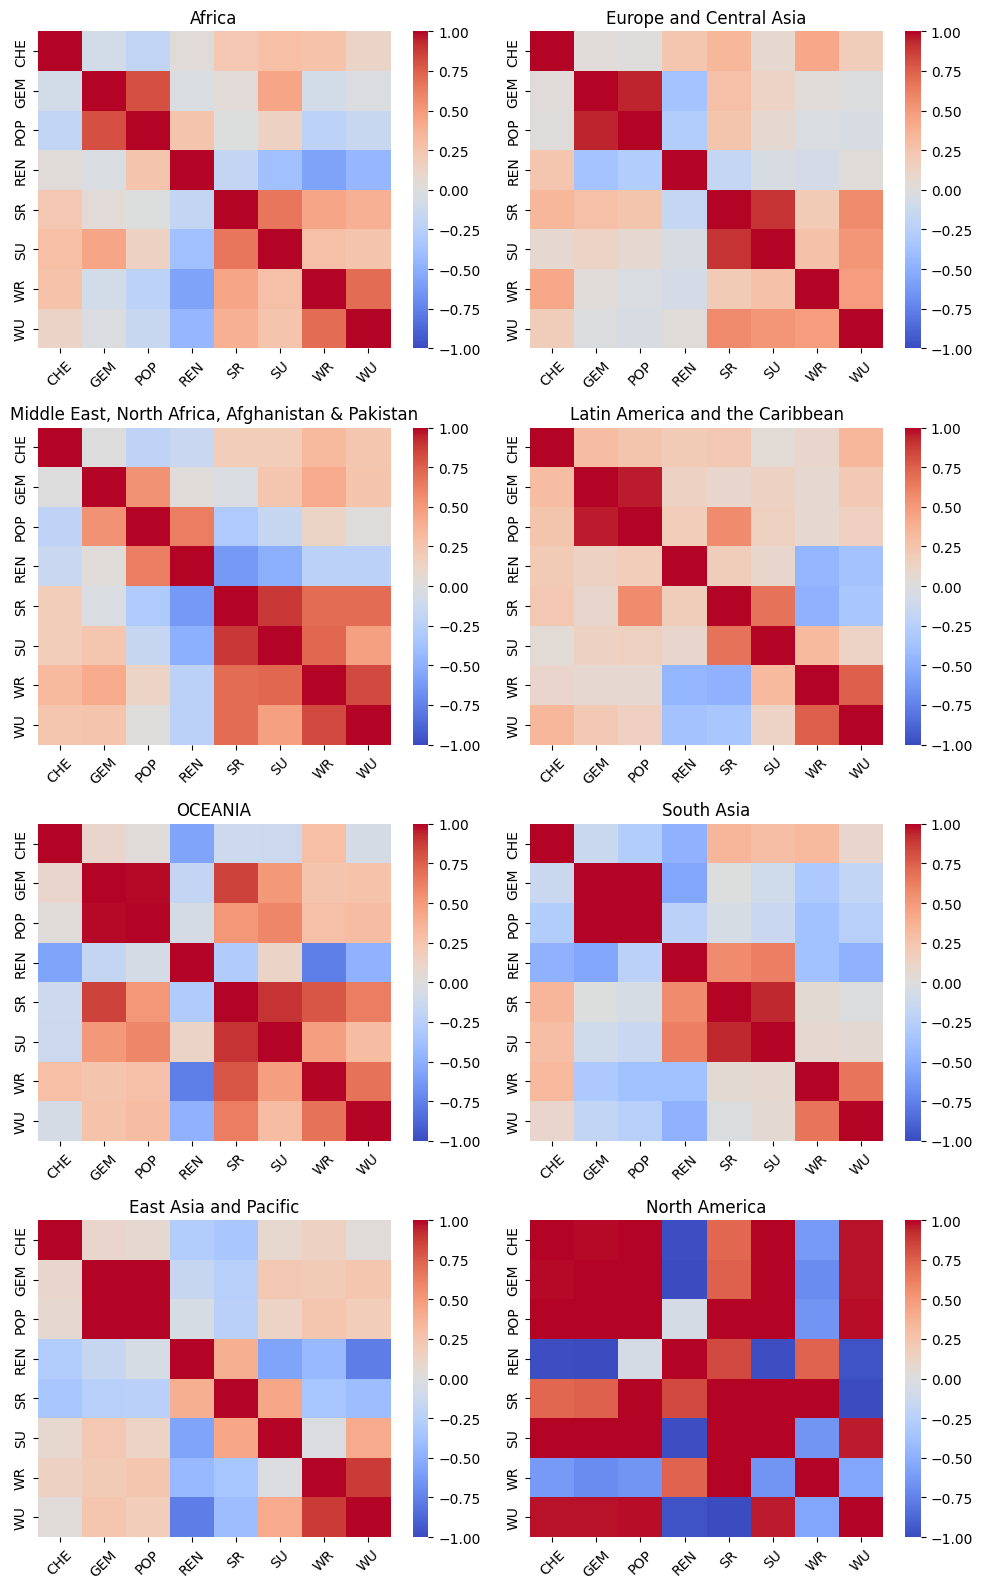

In [ ]:

# Setup Data
region_list = list(df_all_10['region'].unique())
cov_matrices = {}

# Setup the Grid
n_regions = len(region_list)
n_cols = 2  
n_rows = math.ceil(n_regions / n_cols)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows)) # Increased width slightly for better reading
axes = axes.flatten() 

for i, region in enumerate(region_list):
    
    # A. Filter & Pivot
    d_region = df_all_10[df_all_10['region'] == region].copy()
    df_pivot = d_region.pivot_table(
        index=['country_id', 'year'], 
        columns='indicator_id', 
        values='value'
    )
    
    # --- CHANGE 1: Use .corr() directly (No standardization needed) ---
    corr_matrix = df_pivot.corr()
    cov_matrices[region] = corr_matrix
    
    # --- CHANGE 2: Update Visualization for Correlation ---
    sns.heatmap(
        corr_matrix, 
        annot=False, 
        fmt='.2f',          # Standard decimal (e.g., 0.85) is better than scientific notation for correlation
        cmap='coolwarm',    # 'coolwarm' shows Neg (Blue) vs Pos (Red) better than 'Blues'
        center=0, 
        vmin=-1, vmax=1,    # Lock the scale: -1 is min, +1 is max
        ax=axes[i], 
        cbar=True
    )
    
    axes[i].set_title(f"{region}")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
    axes[i].tick_params(axis='x', rotation=45)

# Clean up empty spots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [94]:
# zip(keys, values) creates pairs
id_to_name = dict(zip(df_all_10['indicator_id'], df_all_10['indicator_name']))
id_to_name

{'CHE': 'Current health expenditure',
 'GEM': 'Total greenhouse gas emissions including LULUCF',
 'POP': 'Population total',
 'REN': 'Renewable energy consumption',
 'WR': 'People using at least basic drinking water services rural',
 'WU': 'People using at least basic drinking water services urban',
 'SU': 'People using safely managed sanitation services urban',
 'SR': 'People using safely managed sanitation services rural'}

- We see that correlation and standardized covariance produce the same results
- All regions show a tendency to a similar behaviour apart from North america


## 3c Perform NMF

In [95]:
''' Build a data set that contains the indicators variables 
(there should be at least 6 from two different data sets) as columns, 
and the countries as rows. 
The cells should correspond to averages over the last 10 years.'''

' Build a data set that contains the indicators variables \n(there should be at least 6 from two different data sets) as columns, \nand the countries as rows. \nThe cells should correspond to averages over the last 10 years.'

In [105]:
df_all_10.isna().sum()

country_id        0
indicator_id      0
year              0
value             0
country_name      0
region            0
indicator_name    0
unit              0
dtype: int64

In [97]:
df_pivot_3c = df_all_10.pivot_table(columns = 'indicator_id', index = 'country_id', values='value')
df_pivot_3c

indicator_id,CHE,GEM,POP,REN,SR,SU,WR,WU
country_id,,,,,,,,
AGO,2.608620,140.87373,27726545.4,49.93,NaN,NaN,26.492311,69.879157
ALB,6.459701,10.66337,2885364.1,38.51,NaN,33.569723,90.287764,95.421217
AND,7.117072,NaN,75400.8,18.53,92.038948,92.038948,100.000000,100.000000
ARE,3.755514,238.36922,8257433.8,0.19,98.502937,98.439311,99.997606,99.899200
ARG,9.890686,403.82139,43208216.7,9.53,NaN,45.906680,92.569186,99.511549
...,...,...,...,...,...,...,...,...
XKX,NaN,NaN,1796156.3,NaN,NaN,NaN,NaN,NaN
YEM,4.998320,38.34301,30786609.2,1.79,NaN,61.898528,44.350315,75.976368
ZAF,8.015504,560.98069,55921458.8,8.21,NaN,70.708789,78.352718,98.848956


NMF will crush with NaNs. So we shall imputate withthe mean of the whole table

In [107]:
#Check NaNs
print(f"Total NaNs in Pivot: {df_pivot_3c.isnull().sum().sum()}")

# See which indicators have the most missing countries
print(df_pivot_3c.isnull().sum())

Total NaNs in Pivot: 388
indicator_id
CHE     29
GEM     40
POP      0
REN      7
SR     127
SU      99
WR      49
WU      37
dtype: int64


In [108]:
# Fill NaNs with the average the specific column- that is the indicator in various countries
df_pivot_3c_ = df_pivot_3c.fillna(df_pivot_3c.mean())

# Verify
print("Remaining NaNs:", df_pivot_3c_.isnull().sum().sum())

Remaining NaNs: 0


In [109]:
#We scale the data but not becoming normalized, but rather with the MinMax so that we do not get zeros
#They will all be between 0 and 1
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_pivot_3c_)


In [114]:
#NMF
n_components = 3  
nmf_model = NMF(n_components=n_components, init='nndsvd', random_state=42, max_iter= 2000 )
W = nmf_model.fit_transform(df_scaled)  # Country Features
H = nmf_model.components_             # Indicator Features


In [115]:
type(W)

numpy.ndarray

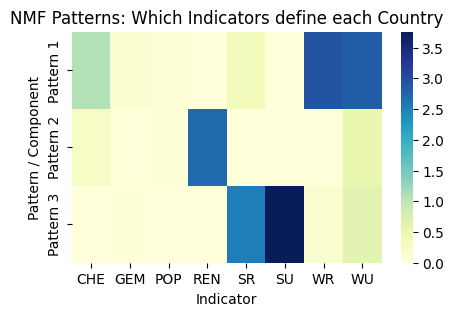

In [119]:
# A. The "Topic Definitions" (Matrix H)
# This tells us: "What indicators make up Component 0?"
df_components = pd.DataFrame(H, columns=df_pivot.columns, index=[f'Pattern {i+1}' for i in range(n_components)])

plt.figure(figsize=(5, 3))
sns.heatmap(df_components, cmap='YlGnBu', annot=False)
plt.title("NMF Patterns: Which Indicators define each Country")
plt.xlabel("Indicator")
plt.ylabel("Pattern / Component")
plt.show()

In [121]:
#The "Country Groupings" (Matrix W)
# This assigns every country a score for each pattern
df_country_scores = pd.DataFrame(W, index=df_pivot_3c_.index, columns=[f'Pattern {i+1}' for i in range(n_components)])

# Show the top countries for Pattern 1
print("Top Countries for Pattern 1:")
print(df_country_scores['Pattern 1'].sort_values(ascending=False).head(5))

Top Countries for Pattern 1:
country_id
TUV    0.367637
ARM    0.349279
USA    0.348303
FRA    0.342226
BEL    0.340628
Name: Pattern 1, dtype: float64


In [122]:
W

array([[0.03195145, 0.19132316, 0.14626344],
       [0.28194856, 0.14447501, 0.0993918 ],
       [0.31047343, 0.06611017, 0.2668901 ],
       [0.30002505, 0.        , 0.28900757],
       [0.32263484, 0.04057301, 0.12069915],
       [0.34927903, 0.03872572, 0.03591712],
       [0.25859086, 0.00311036, 0.13675795],
       [0.25377612, 0.00242435, 0.13743444],
       [0.33557018, 0.0360907 , 0.13114081],
       [0.31576372, 0.12704004, 0.28858577],
       [0.27272817, 0.01116777, 0.14358064],
       [0.16930344, 0.35027672, 0.13918272],
       [0.34062819, 0.03532215, 0.13040477],
       [0.1304634 , 0.17720808, 0.        ],
       [0.11097122, 0.3032731 , 0.0225199 ],
       [0.29205939, 0.12145102, 0.05979733],
       [0.31381294, 0.06318647, 0.17859744],
       [0.25018946, 0.00037887, 0.13799232],
       [0.25533829, 0.00659463, 0.13714577],
       [0.31386552, 0.08567275, 0.08343771],
       [0.3006425 , 0.0233265 , 0.20636985],
       [0.28982006, 0.13376092, 0.13468365],
       [0.

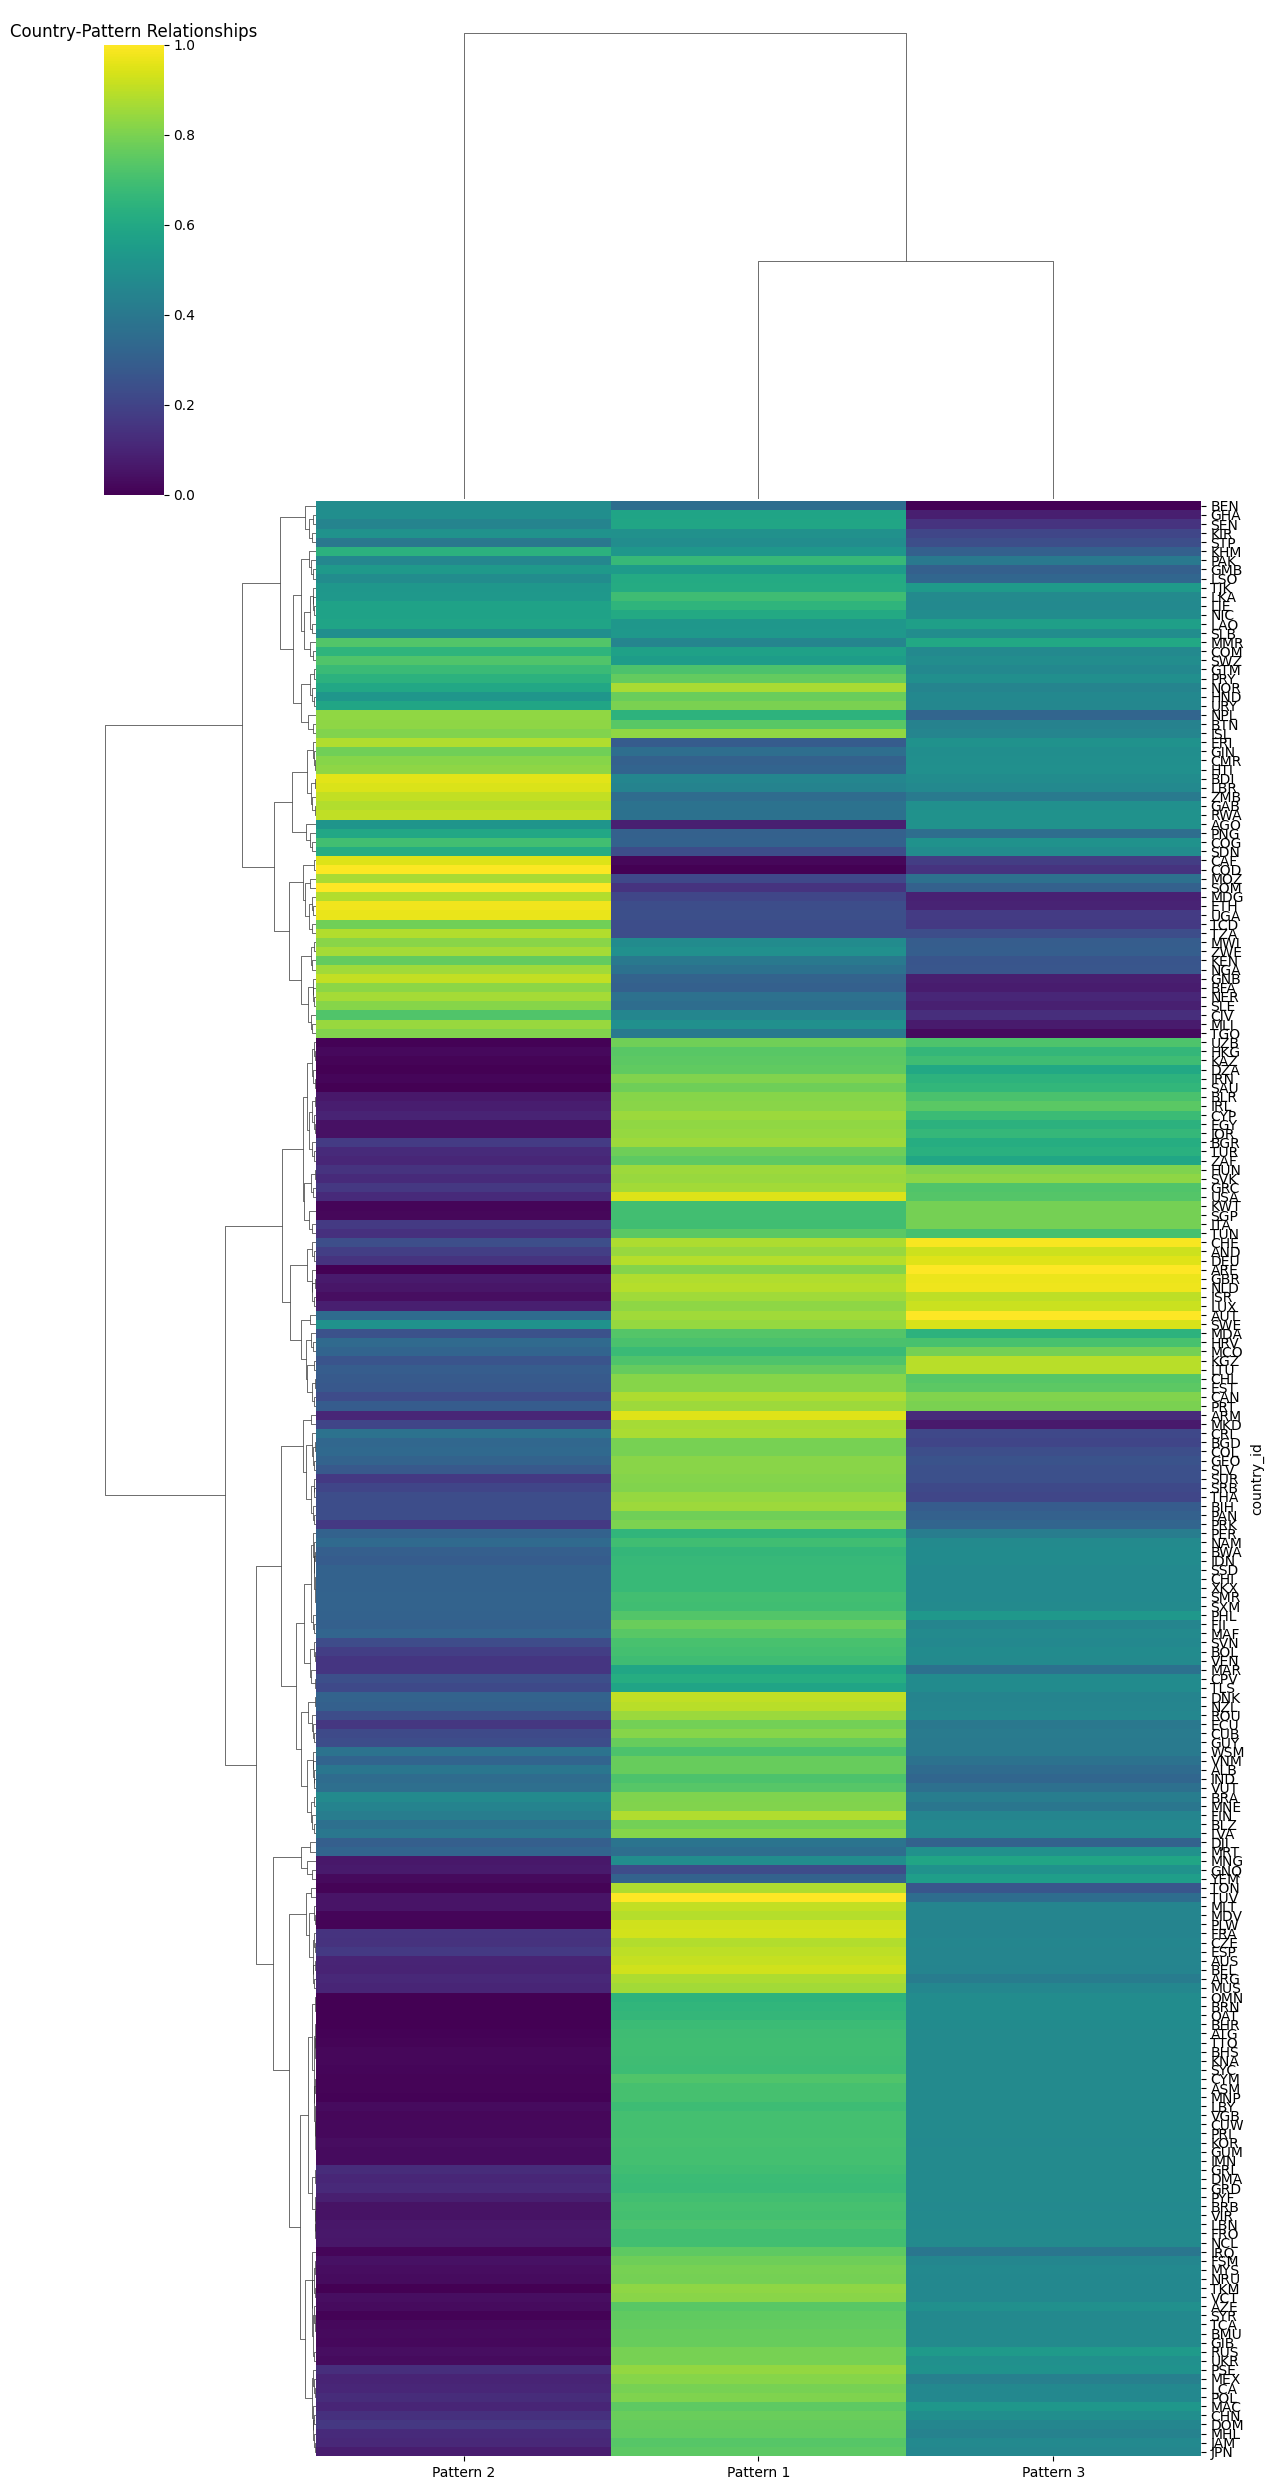

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Setup Data
# Ensure you are using the W matrix (Country Scores)
# df_country_scores index = Country IDs, columns = Pattern 1, Pattern 2...

# 2. Create Clustermap
# method='ward' creates the tightest/cleanest clusters
# standard_scale=1 normalizes columns so one pattern doesn't look brighter just because it has bigger numbers
g = sns.clustermap(
    df_country_scores,
    cmap='viridis',       # 'viridis' or 'magma' are excellent for intensity
    method='ward',        # Clustering algorithm
    standard_scale=1,     # Normalize range 0-1 for fairer comparison
    figsize=(12, 25),     # Tall figure to make room for Country Names
    row_cluster=True,     # Group Countries (The Tree on the Left)
    col_cluster=True,     # Group Patterns (The Tree on the Top)
    yticklabels=True      # Show country names (might be crowded if you have 200 countries)
)

plt.title("Country-Pattern Relationships")
plt.show()